## Packages installation

In [1]:
! pip install -q -U tensorflow-text
! pip install -q -U tf-models-official
# ! pip install -U tfds-nightly

     |████████████████████████████████| 4.4 MB 5.5 MB/s 
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
     |████████████████████████████████| 90 kB 8.3 MB/s 
     |████████████████████████████████| 1.2 MB 32.8 MB/s 
     |████████████████████████████████| 99 kB 6.5 MB/s 
     |████████████████████████████████| 211 kB 38.8 MB/s 
     |████████████████████████████████| 352 kB 43.9 MB/s 
     |████████████████████████████████| 636 kB 42.7 MB/s 
     |████████████████████████████████| 1.1 MB 47.3 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 


## Imports

In [2]:
import os
import tensorflow as tf
print("TensorFlow version " + tf.__version__)

import tensorflow_hub as hub
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


tf.get_logger().setLevel('ERROR')

# TPU
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

TensorFlow version 2.6.0


## Helpers

In [3]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# def clean(text):
#     for punctuation in string.punctuation:
#         text = text.replace(punctuation, ' ') # Remove Punctuation
#     lowercased = text.lower() # Lower Case
#     tokenized = word_tokenize(lowercased) # Tokenize
#     words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
#     stop_words = set(stopwords.words('english')) # Make stopword list
#     without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
#     lemma = WordNetLemmatizer() # Initiate Lemmatizer
#     lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
#     return ' '.join(word for word in lemmatized)

def clean(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    # stop_words = set(stopwords.words('english')) # Make stopword list
    # without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    # lemma = WordNetLemmatizer() # Initiate Lemmatizer
    # lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return ' '.join(word for word in words_only)

def plot_loss(history, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')

    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('Recall')
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=1)
    ax3.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)

def get_metrics(y_test, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

def get_metrics_ds(y_test, ds, model):

    y_prob = model.predict(ds)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Connect to TPU worker

In [4]:
import os

if os.environ['COLAB_TPU_ADDR']:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print('Using TPU')
elif tf.test.is_gpu_available():
    strategy = tf.distribute.MirroredStrategy()
    print('Using GPU')
else:
    raise ValueError('Running on CPU is not recommended.')

Using TPU


## Loading Datasets

### `Politifacts`

In [5]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_P = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_P shape: {data_P.shape}")
print('-'*80)
print('-'*80)
print(data_P['category'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts()/len(data_P)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_P shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [6]:
X_P = data_P['statement'].apply(clean).copy()
y_P = data_P['category2'].copy()

print('-'*80)
print(f"X_P shape: {X_P.shape}")
print(f"y_P shape: {y_P.shape}")
print('-'*80)
print(f"Original text: {data_P['statement'][0]}")
print(f"Clean text: {X_P[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_P shape: (19826,)
y_P shape: (19826,)
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: washington public school forces unvaccinated teens to wear ankle monitors as a condition of playing team sports
--------------------------------------------------------------------------------


In [7]:
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_P_train shape: {X_P_train.shape}")
print(f"y_P_train shape: {y_P_train.shape}")
print('-'*80)
print(f"X_P_test shape: {X_P_test.shape}")
print(f"y_P_test shape: {y_P_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_P_train.sum()/len(y_P_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_P_test.sum()/len(y_P_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train shape: (15860,)
y_P_train shape: (15860,)
--------------------------------------------------------------------------------
X_P_test shape: (3966,)
y_P_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


### `FakeNewsNET`

In [8]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/FakesNewsNET.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_FNN = get_data_from_gcp(nrows=20000)

print('-'*80)
print(f"data_FNN shape: {data_FNN.shape}")
print('-'*80)

--------------------------------------------------------------------------------
data_FNN shape: (19281, 8)
--------------------------------------------------------------------------------


In [9]:
X_FNN = data_FNN['title'].apply(clean).copy()
y_FNN = data_FNN['category'].copy()

print('-'*80)
print(f"X_FNN shape: {X_FNN.shape}")
print(f"y_FNN shape: {y_FNN.shape}")
print('-'*80)
print(f"Original text: {data_FNN['title'][0]}")
print(f"Clean text: {X_FNN[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN shape: (19281,)
y_FNN shape: (19281,)
--------------------------------------------------------------------------------
Original text: Djou wins special election for Congress
Clean text: djou wins special election for congress
--------------------------------------------------------------------------------


In [10]:
X_FNN_train, X_FNN_test, y_FNN_train, y_FNN_test = train_test_split(X_FNN, y_FNN, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_FNN_train shape: {X_FNN_train.shape}")
print(f"y_FNN_train shape: {y_FNN_train.shape}")
print('-'*80)
print(f"X_FNN_test shape: {X_FNN_test.shape}")
print(f"y_FNN_test shape: {y_FNN_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_FNN_train.sum()/len(y_FNN_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_FNN_test.sum()/len(y_FNN_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train shape: (15424,)
y_FNN_train shape: (15424,)
--------------------------------------------------------------------------------
X_FNN_test shape: (3857,)
y_FNN_test shape: (3857,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 24.870
Fake (1) proportion in test (%): 23.568
--------------------------------------------------------------------------------


### `Bisaillon`

In [11]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [12]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [13]:
true['category'] = 0
fake['category'] = 1

data_BIS = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data_BIS shape: {data_BIS.shape}")
print('-'*80)
print(f"ratio #true: {len(data_BIS[data_BIS['category']==0])/len(data_BIS)*100:.2f}%")
print(f"ratio #fake: {len(data_BIS[data_BIS['category']==1])/len(data_BIS)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data_BIS shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [14]:
X_BIS = data_BIS['title'].apply(clean).copy()
y_BIS = data_BIS['category'].copy()

print('-'*80)
print(f"X_BIS shape: {X_BIS.shape}")
print(f"y_BIS shape: {y_BIS.shape}")
print('-'*80)
print(f"Original text: {data_BIS['title'][0]}")
print(f"Clean text: {X_BIS[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS shape: (44689,)
y_BIS shape: (44689,)
--------------------------------------------------------------------------------
Original text: As U.S. budget fight looms, Republicans flip their fiscal script
Clean text: as u s budget fight looms republicans flip their fiscal script
--------------------------------------------------------------------------------


In [15]:
X_BIS_train, X_BIS_test, y_BIS_train, y_BIS_test = train_test_split(X_BIS, y_BIS, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_BIS_train shape: {X_BIS_train.shape}")
print(f"y_BIS_train shape: {y_BIS_train.shape}")
print('-'*80)
print(f"X_BIS_test shape: {X_BIS_test.shape}")
print(f"y_BIS_test shape: {y_BIS_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_BIS_train.sum()/len(y_BIS_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_BIS_test.sum()/len(y_BIS_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train shape: (35751,)
y_BIS_train shape: (35751,)
--------------------------------------------------------------------------------
X_BIS_test shape: (8938,)
y_BIS_test shape: (8938,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 52.670
Fake (1) proportion in test (%): 52.003
--------------------------------------------------------------------------------


### `Poynter`

In [16]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/poynter_final_condensed.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_PO = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_PO shape: {data_PO.shape}")
print('-'*80)
print('-'*80)
print(data_PO['label_list_transformed'].value_counts()/len(data_PO)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_PO shape: (14897, 3)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
0.0    50.063771
1.0    49.936229
Name: label_list_transformed, dtype: float64
--------------------------------------------------------------------------------


In [17]:
X_PO = data_PO['title_list'].apply(clean).copy()
y_PO = data_PO['label_list_transformed'].copy()

print('-'*80)
print(f"X_PO shape: {X_PO.shape}")
print(f"y_PO shape: {y_PO.shape}")
print('-'*80)
print(f"Original text: {data_PO['title_list'][0]}")
print(f"Clean text: {X_PO[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO shape: (14897,)
y_PO shape: (14897,)
--------------------------------------------------------------------------------
Original text: There is a call for free vaccination in the Ciudad de la Luz center, in Alicante, for people over 12 years old.
Clean text: there is a call for free vaccination in the ciudad de la luz center in alicante for people over years old
--------------------------------------------------------------------------------


In [18]:
X_PO_train, X_PO_test, y_PO_train, y_PO_test = train_test_split(X_PO, y_PO, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_PO_train shape: {X_PO_train.shape}")
print(f"y_PO_train shape: {y_PO_train.shape}")
print('-'*80)
print(f"X_PO_test shape: {X_PO_test.shape}")
print(f"y_PO_test shape: {y_PO_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_PO_train.sum()/len(y_PO_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_PO_test.sum()/len(y_PO_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_PO_train shape: (11917,)
y_PO_train shape: (11917,)
--------------------------------------------------------------------------------
X_PO_test shape: (2980,)
y_PO_test shape: (2980,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 49.870
Fake (1) proportion in test (%): 50.201
--------------------------------------------------------------------------------


### `Alll`

In [19]:
X_ALLL = pd.concat([X_P, X_FNN, X_BIS, X_PO]).sample(frac=1, random_state=42).reset_index(drop=True)
y_ALLL = pd.concat([y_P, y_FNN, y_BIS, y_PO]).sample(frac=1, random_state=42).reset_index(drop=True)

X_ALLL_train, X_ALLL_valtest, y_ALLL_train, y_ALLL_valtest = train_test_split(X_ALLL, y_ALLL, test_size=0.3, random_state=42)
X_ALLL_val, X_ALLL_test, y_ALLL_val, y_ALLL_test = train_test_split(X_ALLL_valtest, y_ALLL_valtest, test_size=0.5, random_state=42)

print('-'*80)
print(f"X_ALLL_train shape: {X_ALLL_train.shape}")
print(f"y_ALLL_train shape: {y_ALLL_train.shape}")
print('-'*80)
print(f"X_ALLL_val shape: {X_ALLL_val.shape}")
print(f"y_ALLL_val shape: {y_ALLL_val.shape}")
print('-'*80)
print(f"X_ALLL_test shape: {X_ALLL_test.shape}")
print(f"y_ALLL_test shape: {y_ALLL_test.shape}")
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ALLL_train.sum()/len(y_ALLL_train)*100:.3f}")
print(f"Fake (1) proportion in val (%): {y_ALLL_val.sum()/len(y_ALLL_val)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ALLL_test.sum()/len(y_ALLL_test)*100:.3f}")
print('-'*80)
print('### TRAIN ###')
print('-'*80)
print(f"Politifact ratio: {X_P_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"FakeNewsNET ratio: {X_FNN_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"Bisaillon ratio: {X_BIS_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print(f"Poynter ratio: {X_PO_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
print('-'*80)
print('### TEST ###')
print('-'*80)
print(f"Politifact ratio: {X_P_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"FakeNewsNET ratio: {X_FNN_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"Bisaillon ratio: {X_BIS_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print(f"Poynter ratio: {X_PO_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALLL_train shape: (69085,)
y_ALLL_train shape: (69085,)
--------------------------------------------------------------------------------
X_ALLL_val shape: (14804,)
y_ALLL_val shape: (14804,)
--------------------------------------------------------------------------------
X_ALLL_test shape: (14804,)
y_ALLL_test shape: (14804,)
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 47.143
Fake (1) proportion in val (%): 47.035
Fake (1) proportion in test (%): 46.454
--------------------------------------------------------------------------------
### TRAIN ###
--------------------------------------------------------------------------------
Politifact ratio: 0.23
FakeNewsNET ratio: 0.22
Bisaillon ratio: 0.52
Poynter ratio: 0.17
--------------------------------------------------------------------------------
### TEST ###
-----------------------------

In [20]:
# X_ALLL_train = pd.concat([X_P_train, X_FNN_train, X_BIS_train, X_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)
# y_ALLL_train = pd.concat([y_P_train, y_FNN_train, y_BIS_train, y_PO_train]).sample(frac=1, random_state=42).reset_index(drop=True)

# X_ALLL_test = pd.concat([X_P_test, X_FNN_test, X_BIS_test, X_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)
# y_ALLL_test = pd.concat([y_P_test, y_FNN_test, y_BIS_test, y_PO_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# print('-'*80)
# print(f"X_ALLL_train shape: {X_ALLL_train.shape}")
# print(f"y_ALLL_train shape: {y_ALLL_train.shape}")
# print('-'*80)
# print(f"X_ALLL_test shape: {X_ALLL_test.shape}")
# print(f"y_ALLL_test shape: {y_ALLL_test.shape}")
# print('-'*80)
# print('-'*80)
# print(f"Fake (1) proportion in train (%): {y_ALLL_train.sum()/len(y_ALLL_train)*100:.3f}")
# print(f"Fake (1) proportion in test (%): {y_ALLL_test.sum()/len(y_ALLL_test)*100:.3f}")
# print('-'*80)
# print('### TRAIN ###')
# print('-'*80)
# print(f"Politifact ratio: {X_P_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
# print(f"FakeNewsNET ratio: {X_FNN_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
# print(f"Bisaillon ratio: {X_BIS_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
# print(f"Poynter ratio: {X_PO_train.shape[0]/X_ALLL_train.shape[0]:.2f}")
# print('-'*80)
# print('### TEST ###')
# print('-'*80)
# print(f"Politifact ratio: {X_P_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
# print(f"FakeNewsNET ratio: {X_FNN_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
# print(f"Bisaillon ratio: {X_BIS_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
# print(f"Poynter ratio: {X_PO_test.shape[0]/X_ALLL_test.shape[0]:.2f}")
# print('-'*80)

## BERT Model

### Model selection

In [21]:
# bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 
# bert_model_name = 'bert_en_uncased_L-24_H-1024_A-16'

In [22]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocessing

In [23]:
def make_bert_preprocess_model():

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    return tf.keras.Model(text_input, encoder_inputs)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset(X, y, bert_preprocess_model, batch_size=32, is_training=True):
    
    X = [np.array([item]) for item in X]
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    num_examples = len(X)

    if is_training:
        dataset = dataset.shuffle(num_examples)
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda X_, y_: (bert_preprocess_model(X_), y_))
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset, num_examples

In [25]:
# Check
# bert_preprocess_model = make_bert_preprocess_model()

# train_dataset, train_data_size = load_dataset(X_ALLL_train, y_ALLL_train, bert_preprocess_model, batch_size=32, is_training=True)
# val_dataset, val_data_size = load_dataset(X_ALLL_val, y_ALLL_val, bert_preprocess_model, batch_size=32, is_training=False)
# test_dataset, test_data_size = load_dataset(X_ALLL_test, y_ALLL_test, bert_preprocess_model, batch_size=32, is_training=False)

### Model

In [26]:
def build_classifier_model():

  class Classifier(tf.keras.Model):
    def __init__(self):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.5)
      self.dense_int = tf.keras.layers.Dense(128, activation='relu')
      self.dense_final = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense_int(x)
      x = self.dropout(x)
      x = self.dense_final(x)
      return x

  model = Classifier()
  
  return model

### Checking - Preprocessing + Model

In [27]:
test_preprocess_model = make_bert_preprocess_model()

test_text = np.array([X_ALLL_train.values[0]])
# test_text = tf.constant(['Hello my name is julien'])

text_preprocessed = test_preprocess_model(test_text)

print("#### Preprocess Output")
print('test_text      : ', test_text)
print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
# print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
# print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
# print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
# print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

test_classifier_model = build_classifier_model()
bert_raw_result = test_classifier_model(text_preprocessed)
print("##### Model Output:")
print(bert_raw_result)

#### Preprocess Output
test_text      :  ['fox news mocks msnbc s chris matthews who actually said big story of was how far president trump and putin spread their legs video']
Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  4419  2739 12934  2015  5796 28957  1055  3782 12351  2040  2941
  2056  2502  2466  1997], shape=(16,), dtype=int32)
##### Model Output:
tf.Tensor([[0.4401542]], shape=(1, 1), dtype=float32)


## Training

In [28]:
# epochs = 15
# batch_size = 256
# init_lr = 2e-5

epochs = 1
batch_size = 128 #32
init_lr = 3e-5 #2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')

bert_preprocess_model = make_bert_preprocess_model()

with strategy.scope():

    train_dataset, train_data_size = load_dataset(X_ALLL_train, y_ALLL_train, bert_preprocess_model, batch_size=batch_size, is_training=True)
    steps_per_epoch = train_data_size // batch_size
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = num_train_steps // 10

    validation_dataset, validation_data_size = load_dataset(X_ALLL_val, y_ALLL_val, bert_preprocess_model, batch_size=batch_size, is_training=False)
    validation_steps = validation_data_size // batch_size

    classifier_model = build_classifier_model()
    # classifier_model.encoder.trainable = False

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]

    loss = tf.keras.losses.BinaryCrossentropy()

    optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw')

    classifier_model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=4, restore_best_weights=True)

    history = classifier_model.fit(
                x=train_dataset,
                validation_data=validation_dataset,
                steps_per_epoch=steps_per_epoch,
                epochs=epochs,
                validation_steps=validation_steps,
                callbacks=[es])

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


539/539 [==============================] - 155s 149ms/step - loss: 0.4463 - accuracy: 0.7706 - precision: 0.7633 - recall: 0.7442 - val_loss: 0.3129 - val_accuracy: 0.8538 - val_precision: 0.8633 - val_recall: 0.8184


## Evaluation

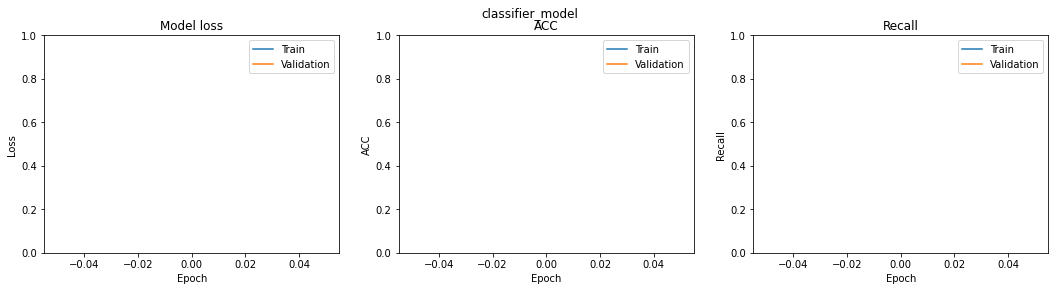

In [29]:
  plot_loss(history, title='classifier_model')

--------------------------------------------------------------------------------
acc: 85.53%
recall: 80.38%
precision: 87.45%
f1: 83.77%
--------------------------------------------------------------------------------


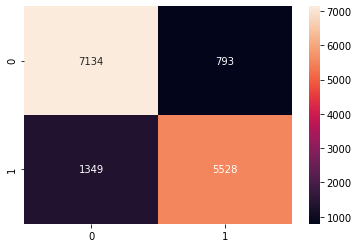

In [30]:
test_dataset, _ = load_dataset(X_ALLL_test, y_ALLL_test, bert_preprocess_model, batch_size=32, is_training=False)

get_metrics_ds(y_ALLL_test, test_dataset, classifier_model)

--------------------------------------------------------------------------------
acc: 84.75%
recall: 82.75%
precision: 84.16%
f1: 83.45%
--------------------------------------------------------------------------------


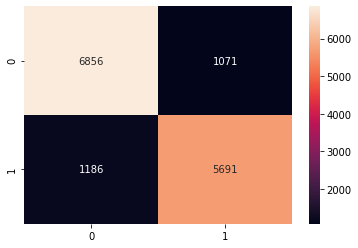

In [ ]:
# CLEAN FULL
# --------------------------------------------------------------------------------
# acc: 84.75%
# recall: 82.75%
# precision: 84.16%
# f1: 83.45%
# --------------------------------------------------------------------------------

# CLEAN - N0 STOPWORDS / LEMMATIZE
# --------------------------------------------------------------------------------
# acc: 87.33%
# recall: 83.80%
# precision: 88.32%
# f1: 86.00%
# --------------------------------------------------------------------------------

# CLEAN - tokenize and lower
# --------------------------------------------------------------------------------
# acc: 88.23%
# recall: 84.96%
# precision: 89.19%
# f1: 87.03%
# --------------------------------------------------------------------------------

# NO CLEANING 
# --------------------------------------------------------------------------------
# acc: 88.24%
# recall: 85.43%
# precision: 88.83%
# f1: 87.10%
# --------------------------------------------------------------------------------

In [ ]:
# PO_dataset, _ = load_dataset(X_PO, y_PO, bert_preprocess_model, batch_size=32, is_training=False)

# get_metrics_ds(y_PO, PO_dataset, classifier_model)

## Saving the model to `Colab`

In [38]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)
# model_for_export.save(saved_model_path, include_optimizer=False)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models/bert_en_uncased_L-12_H-768_A-12


## Saving the model to `Google Drive`

In [ ]:
from google.colab import drive

drive.mount('drive')

google_drive_path = '/content/drive/My Drive/Colab Notebooks/1_Projets/lewagon_final_project'
saved_model_path = os.path.join(google_drive_path, saved_model_name)

save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Mounted at drive


## Uploading the model from `Google Drive`

In [11]:
from google.colab import drive

drive.mount('drive')

bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{bert_type}'
google_drive_path = '/content/drive/My Drive/Colab Notebooks/1_Projets/lewagon_final_project'
saved_model_path = os.path.join(google_drive_path, saved_model_name)

reloaded_model = tf.saved_model.load(saved_model_path)

Mounted at drive


In [13]:
saved_model_name

'bert_en_uncased_L-12_H-768_A-12'

## Prediction

In [30]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_ALLL_test, y_ALLL_test))

for X, y in test_dataset.shuffle(1000).take(10):
    
    y_prob = reloaded_model([X])
    print(f"Label: {y} - Pred: {y_prob.numpy()[0][0]:.3f} - {X.numpy()} ")


Label: 1.0 - Pred: 1.000 - b'an image that compares the main causes of death in the world in with those caused by covid this year' 
Label: 1.0 - Pred: 0.998 - b'using masks causes psychological damage and the restrictions associated with the coronavirus pandemic deprive people of their individualism masks should only be worn by those who are already infected and it is mentally harmful for asymptomatic individuals to wear them' 
Label: 0.0 - Pred: 0.711 - b'says republican state sen alberta darling offered unqualified support for a plan to end medicare' 
Label: 1.0 - Pred: 0.666 - b'a publication date on the website of cnn shows that a video of the first vaccination of a woman in the uk was created in october' 
Label: 0.0 - Pred: 0.003 - b'mcdonald s deletes trump tweet says twitter account compromised' 
Label: 0.0 - Pred: 0.000 - b'trump says has been clear that u s open for trade if fair reciprocal' 
Label: 1.0 - Pred: 0.997 - b'selena gomez justin bieber she s hoping they can double 

In [12]:
samples = ['Julien is 43yo',
           'Nina and Fleur are the daughters of Julien',
           'Trump president']

for sample in samples:
    y_prob = reloaded_model([sample])
    print(f"Pred: {y_prob.numpy()[0][0]:.3f} - {sample} ")

Pred: 0.027 - Julien is 43yo 
Pred: 0.027 - Nina and Fleur are the daughters of Julien 
Pred: 0.000 - Trump president 


In [15]:
BUCKET_NAME = 'wagon-data-615-seguy'
STORAGE_LOCATION = 'models/StopFAIke/bert_en_uncased_L-12_H-768_A-12'
BERT_MODEL_NAME = 'bert_en_uncased_L-12_H-768_A-12'

print("#### Loading the model ...")
reloaded_model = tf.saved_model.load(f"gs://{BUCKET_NAME}/{STORAGE_LOCATION}")


#### Loading the model ...


PermissionDeniedError: ignored

In [ ]:
# sample = 3
# X = [tf.constant(item) for item in X_ALLL_test]
# X = X[:sample]
# print(X)

# y_prob = reloaded_model(X)
# y_prob

In [ ]:
# sample = 2

# X = [tf.constant(item) for item in X_ALLL_test]
# X = X[:sample]
# y = y_ALLL_test.values[1]

# y_prob = reloaded_model(X_FNN_test)

# for claim, label, pred in zip(X, y, y_prob):
#     print('-'*80)
#     print(f"Claim: {X}")
#     print('-'*80)
#     print(f"Label: {label} - Prediction: {pred.numpy()[0][0]:.3f}")
#     print('-'*80)